In [ ]:
"""
    TARGETS:
    - Predict deaths / new infections
    - Predict who can spread to who
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

%matplotlib inline
#sns.set(rc={'figure.figsize':(80,40)})

In [2]:
p_info = pd.read_csv("./korea_dataset/PatientInfo.csv")
p_route = pd.read_csv("./korea_dataset/PatientRoute.csv")

In [20]:
#p_info["disease"][752]
p_info.head(200)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,0,1964.0,50s,Korea,Seoul,Gangseo-gu,1.0,overseas inflow,1.0,NaN,75.0,1/22/20,23,2/05/20,NaN,0
1,1000000002,5.0,0,1987.0,30s,Korea,Seoul,Jungnang-gu,1.0,overseas inflow,1.0,NaN,31.0,NaN,30,3/02/20,NaN,0
2,1000000003,6.0,0,1964.0,50s,Korea,Seoul,Jongno-gu,1.0,contact with patient,2.0,2.002000e+09,17.0,NaN,30,2/19/20,NaN,0
3,1000000004,7.0,0,1991.0,20s,Korea,Seoul,Mapo-gu,1.0,overseas inflow,1.0,NaN,9.0,1/26/20,30,2/15/20,NaN,0
4,1000000005,9.0,1,1992.0,20s,Korea,Seoul,Seongbuk-gu,1.0,contact with patient,2.0,1.000000e+09,2.0,NaN,31,2/24/20,NaN,0
5,1000000006,10.0,1,1966.0,50s,Korea,Seoul,Jongno-gu,1.0,contact with patient,3.0,1.000000e+09,43.0,NaN,31,2/19/20,NaN,0
6,1000000007,11.0,0,1995.0,20s,Korea,Seoul,Jongno-gu,1.0,contact with patient,3.0,1.000000e+09,0.0,NaN,31,2/10/20,NaN,0
7,1000000008,13.0,0,1992.0,20s,Korea,Seoul,etc,1.0,overseas inflow,1.0,NaN,0.0,NaN,33,2/24/20,NaN,0
8,1000000009,19.0,0,1983.0,30s,Korea,Seoul,Songpa-gu,1.0,overseas inflow,2.0,NaN,68.0,NaN,36,2/21/20,NaN,0
9,1000000010,21.0,1,1960.0,60s,Korea,Seoul,Seongbuk-gu,1.0,contact with patient,3.0,1.000000e+09,6.0,NaN,36,2/29/20,NaN,0


In [4]:
infected_by = p_info["infected_by"].ravel()
contact_number = p_info["contact_number"].ravel()
deceased_date = p_info["deceased_date"].ravel()
patient_id = p_info["patient_id"].ravel()

In [5]:
d_disease = {"TRUE": 0, "FALSE": 1}
d_gender = {"male": 0, "female": 1, "n/a": 2}
d_state = {"released": 0, "isolated": 1, "deceased": 2}

In [6]:
p_info["disease"].fillna("FALSE", inplace=True)
p_info["disease"] = p_info["disease"].map(d_disease)

In [7]:
for count, disease in enumerate(p_info["disease"], 0):
    if math.isnan(disease):
        p_info.at[count, "disease"] = "1.0"

In [8]:
p_info["sex"].fillna("n/a", inplace=True)
p_info["sex"] = p_info["sex"].map(d_gender)

In [9]:
p_info["state"] = p_info["state"].map(d_state)

In [10]:
# Converts string date to 
def nth_day(d, format="%m/%d/%y"):
    d = pd.to_datetime(d, format=format)
    day = pd.Timestamp(year=d.year, month=1, day=1)
    return int((d-day).days + 1)

In [11]:
for count, cd in enumerate(p_info["confirmed_date"], 0):
    p_info.at[count, "confirmed_date"] = int(nth_day(str(cd)))

In [19]:
copy = p_info[p_info["released_date"].notna()]
for count, rd in enumerate(copy["released_date"], 0):
    copy.loc[count, "released_date"] = copy.loc[count, "released_date"].replace(rd, str(nth_day(str(rd))))

KeyError: 12

In [16]:
cd_avg = int(ccc["released_date"].values.mean())
p_info["released_date"].fillna(cd_avg, inplace=True)

y = p_info["released_date"].ravel()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [82]:
d_infection_case = {}
d_city = {}
d_province = {}
d_country = {}

infection_case_counter = 0
city_counter = 0
province_counter = 0
country_counter = 0

p_info["infection_case"].fillna("etc", inplace=True)
p_info["city"].fillna("etc", inplace=True)
p_info["country"].fillna("etc", inplace=True)

for case in p_info["infection_case"]:
    if case not in d_infection_case:
        d_infection_case[str(case)] = infection_case_counter
        infection_case_counter += 1

# TODO: Modify - add props. -gu, -gun, -si with regex
for city in p_info["city"]:
    if city not in d_city:
        d_city[str(city)] = city_counter
        city_counter += 1

# TODO: Modify - add props. Special City / Metropolitan City / Province(-do) with regex
for province in p_info["province"]:
    if province not in d_province:
        d_province[str(province)] = province_counter
        province_counter += 1

for country in p_info["country"]:
    if country not in d_country:
        d_country[str(country)] = country_counter
        country_counter += 1

p_info["infection_case"] = p_info["infection_case"].map(d_infection_case)
p_info["city"] = p_info["city"].map(d_city)
p_info["province"] = p_info["province"].map(d_province)
p_info["country"] = p_info["country"].map(d_country)

In [17]:
year = date.today().year

# 0 - indicates nan
p_info["age"].fillna(0, inplace=True)
p_info["birth_year"].fillna(0, inplace=True)

for count, age in enumerate(p_info["age"], 0):
    birth = p_info["birth_year"][count]
    
    if age == 0 and birth == 0:
        continue
    elif age != 0 and birth == 0:
        # No birth date recorded
        age = age[:-1] 
        born = int(year-int(age))
        p_info.at[count, "birth_year"] = born
    else:
        n_age = int(year-int(birth))
        p_info.at[count, "age"] = n_age

c_info = p_info[p_info["age"] != 0]
c_info = p_info[p_info["birth_year"] != 0]

print(c_info.head())
a_avg = int(c_info["age"].values.mean())
b_avg = int(c_info["birth_year"].values.mean())

for count, age in enumerate(p_info["age"], 0):
    birth = p_info["birth_year"][count]
    
    if age == 0 and birth == 0:
        p_info.at[count, "age"] = str(a_avg)
        p_info.at[count, "birth_year"] = str(b_avg)

   patient_id  global_num  sex  birth_year age  country  province  city  \
0  1000000001         2.0    0      1964.0  56        0         0     0   
1  1000000002         5.0    0      1987.0  33        0         0     1   
2  1000000003         6.0    0      1964.0  56        0         0     2   
3  1000000004         7.0    0      1991.0  29        0         0     3   
4  1000000005         9.0    1      1992.0  28        0         0     4   

   disease  infection_case  infection_order   infected_by  contact_number  \
0      1.0               0              1.0           NaN            75.0   
1      1.0               0              1.0           NaN            31.0   
2      1.0               1              2.0  2.002000e+09            17.0   
3      1.0               0              1.0           NaN             9.0   
4      1.0               1              2.0  1.000000e+09             2.0   

  symptom_onset_date confirmed_date released_date deceased_date  state  
0            

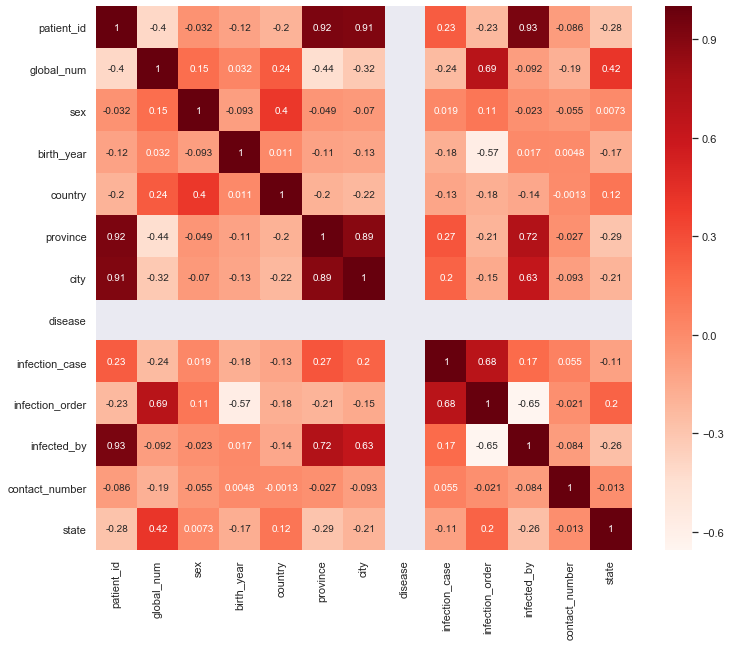

In [155]:
plt.figure(figsize=(12,10))
cor = p_info.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [161]:
c_target = abs(cor["patient_id"])

rel_feat = c_target[c_target > 0.5]
print(rel_feat)

patient_id     1.000000
province       0.924829
city           0.910334
infected_by    0.931708
Name: patient_id, dtype: float64
<class 'numpy.int64'>


In [19]:
p_info.drop("global_num", axis=1, inplace=True)
p_info.drop("infection_order", axis=1, inplace=True)
p_info.drop("symptom_onset_date", axis=1, inplace=True)
p_info.drop("infected_by", axis=1, inplace=True)
p_info.drop("contact_number", axis=1, inplace=True)
p_info.drop("deceased_date", axis=1, inplace=True)
p_info.drop("patient_id", axis=1, inplace=True)
p_info.drop("released_date", axis=1, inplace=True)
p_info.drop("birth_year", axis=1, inplace=True)
p_info.drop("disease", axis=1, inplace=True)

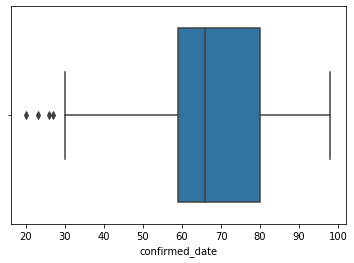

In [21]:
sns.boxplot(x=p_info["confirmed_date"])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(p_info, y, test_size=0.25, random_state=1)

In [19]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
train_pred = reg.predict(X_test)

In [21]:
print(math.sqrt(y_test.min()))
print(math.sqrt(y_test.max()))

6.082762530298219
10.862780491200215


In [22]:
#print(X_test)
#print(y_test)
#print(train_pred)

# Goal is to get to 74 or 7.4

In [46]:
print(math.sqrt(mean_squared_error(y_test, train_pred))) # Falls between 6<x<10 -> 9.4
print(r2_score(y_test, train_pred))

9.77339897806705
0.7063429250238944


In [177]:
#d_train = xgb.DMatrix(X_train, label=y_train)
#d_test = xgb.DMatrix(X_test, label=y_test)

In [36]:
gpr = GaussianProcessRegressor(optimizer="fmin_l_bfgs_b", random_state=0)
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=0)

In [37]:
grp_tp = gpr.predict(X_test)
#print(grp_tp)

In [39]:
print(math.sqrt(mean_squared_error(y_test, grp_tp))) # halfway between 61 & 108 is 84 <- 88 is above 50%

88.78435718387274
